Compilation
--

https://gotm.net/portfolio/software/

Needs fortran bindings for netcdf, which must be made with the same compiler as
used to compile gotm. New branch of make_dfm created that handles the relatively
small compile.

At least in the past it was dependent on editscenario: `pip install editscenario`. Seems like
current version may actually read yaml files directly.

The output is not compatible with xarray due to dimension/coordinate clashes. One 
approach [link](https://stackoverflow.com/questions/55109481/how-to-import-netcdf4-file-with-xarray-when-index-names-have-multiple-dimensions) is to rename variables in the file with `nco`. Installing `nco` conflicts with gotm (netcdf library versions).

Added wrapper in stompy.xr_utils.

In [167]:
import os
import xarray as xr
import six
from stompy import utils
import datetime
import netCDF4
import matplotlib.pyplot as plt
import subprocess
import numpy as np
%matplotlib widget

In [8]:
def setup_gotm():
    os.environ['LD_LIBRARY_PATH']=":".join([
        os.path.join(os.environ['CONDA_PREFIX'],"lib"),
        "/opt/intel/oneapi/compiler/2023.1.0/linux/compiler/lib/intel64_lin"
    ])
setup_gotm()

In [ ]:
# Attempt the rouse case
#  so gotm can write a yaml file
#  Maybe gotm reads that yaml directly? I didn't have to actually run

In [44]:
from stompy import xr_utils
six.moves.reload_module(xr_utils)

nc_fn="../gotm/cases/rouse/rouse.nc"
ds=xr_utils.xr_open_with_rename(nc_fn,dict(z="z_coord",zi="zi_coord"))

In [45]:
ds

<xarray.Dataset>
Dimensions:     (time: 101, lon: 1, lat: 1, z: 110, zi: 111)
Coordinates:
  * time        (time) datetime64[ns] 1998-01-01 ... 1998-01-02
  * lon         (lon) float32 0.0
  * lat         (lat) float32 0.0
    z_coord     (time, z, lat, lon) float32 -109.5 -108.5 -107.5 ... -1.5 -0.5
    zi_coord    (time, zi, lat, lon) float32 -110.0 -109.0 ... -1.0 -3.642e-13
Dimensions without coordinates: z, zi
Data variables: (12/105)
    zeta        (time, lat, lon) float32 ...
    u_taus      (time, lat, lon) float32 ...
    Hice        (time, lat, lon) float32 ...
    u10         (time, lat, lon) float32 ...
    v10         (time, lat, lon) float32 ...
    airt        (time, lat, lon) float32 ...
    ...          ...
    us0         (time, lat, lon) float32 ...
    vs0         (time, lat, lon) float32 ...
    ds          (time, lat, lon) float32 ...
    Ekin        (time, lat, lon) float32 ...
    Epot        (time, lat, lon) float32 ...
    Eturb       (time, lat, lon) float32 ...
Attributes:
    title:    GOTM Simulation
    comment:  file created by flexout - https://github.com/BoldingBruggeman/f...

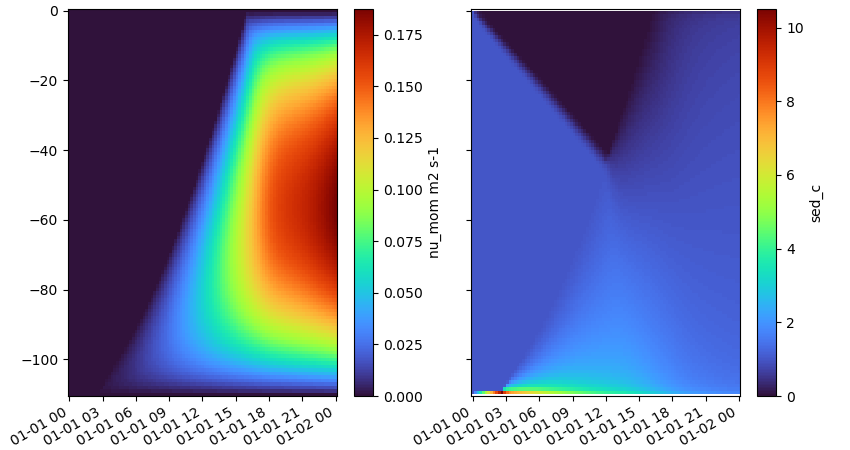

In [51]:
# Check output from simple rouse profile run
site=ds.isel(lat=0,lon=0)
fig,(ax,ax_sed)=plt.subplots(1,2,sharex=True,sharey=True,figsize=(8.5,4.5))
x,y = xr.broadcast( site.time, site.zi_coord)
coll=ax.pcolormesh( x,y,site.num, cmap='turbo')
plt.colorbar(coll,label='nu_mom m2 s-1')

x,y = xr.broadcast( site.time, site.z_coord)
coll=ax_sed.pcolormesh( x,y,site.sed_c, cmap='turbo')
plt.colorbar(coll,label='sed_c')

fig.autofmt_xdate()
fig.subplots_adjust(top=0.98,right=0.95,left=0.08,bottom=0.12)

In [212]:
# Adjust for a buoyant tracer:
import golumn
six.moves.reload_module(golumn)


glm = golumn.Golumn()
glm.fabm_yaml['instances']['sed']['parameters']['vertical_velocity'] = 10.0 # 10 m/d up 
glm.gotm_yaml['time']['stop'] = datetime.datetime(1998,1,5,0,0) # run longer for buoyant case
glm.run()

 ------------------------------------------------------------------------
 GOTM started on 2023/10/26 at 04:05:28
 ------------------------------------------------------------------------
    initialize_gotm
 ------------------------------------------------------------------------
        Reading configuration from: gotm.yaml
        configuring modules ....
    init_airsea_yaml
        done
            
 without STIM.
            
 To change this, specify -DGOTM_USE_STIM=ON when running cmake, then rebuild GOT
 M.
    init_observations_yaml
    init_stokes_drift_yaml
        done
    init_turbulence_yaml
        done.
            
 t CVMix.
            
 To change this, specify -DGOTM_USE_CVMIX=ON when running cmake, then rebuild GO
 TM.
    init_gotm_fabm_yaml
        Reading configuration from:
            fabm.yaml
        done.
    init_meanflow_yaml
        done
    init_eqstate_yaml
    init_density()
            rho0=     1027.00000000000     
        done.
        GOTM Simulat

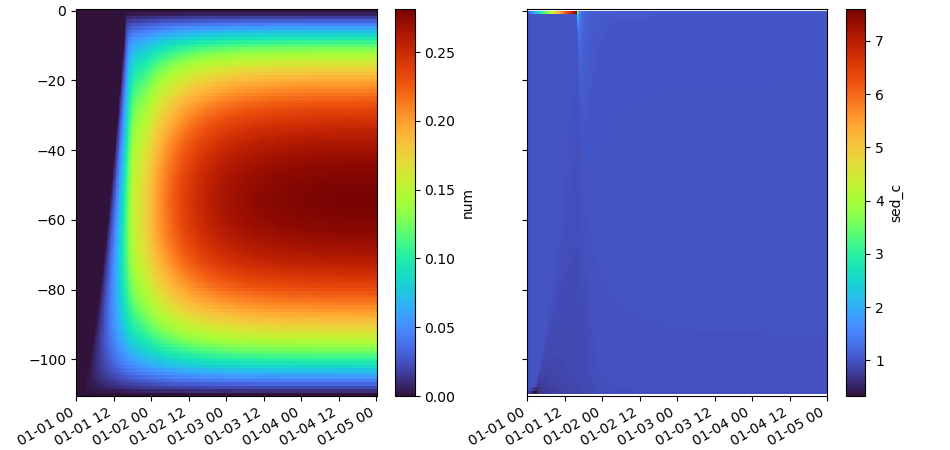

In [213]:
# Check output from simple rouse profile run

fig=glm.fig_time_z(['num','sed_c'])

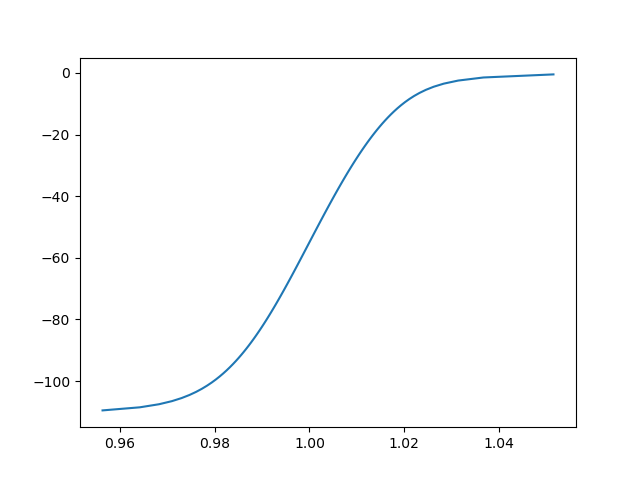

In [146]:
# Show a profile of that:
fig,ax = plt.subplots()
snap=glm.results.isel(time=-1)
ax.plot(snap.sed_c, snap.z_coord)

Unsteady Mixing
--
Want to see whether a "real" turbulence field shows the same lag in mixing that 
that DFM suggests, and whether it affects phyto distribution.

To that end, create neap-ish SF Bay conditions, M2 tides. Compare my simplified
water column turbulence to GOTM via eddy viscosity.

Can force depth-averaged velocity.

In [208]:
# Tidal forcing:

glm = Golumn()
glm.fabm_yaml['instances']['sed']['parameters']['vertical_velocity'] = 10.0 # 10 m/d up 
glm.gotm_yaml['time']['stop'] = datetime.datetime(1998,1,3,0,0) # run longer for buoyant case
glm.gotm_yaml['mimic_3d']['ext_pressure']['type'] = 'average_velocity'
glm.gotm_yaml['mimic_3d']['ext_pressure']['dpdx']['method'] = 'tidal'
glm.gotm_yaml['mimic_3d']['ext_pressure']['dpdx']['tidal'] = dict(amp_1=0.5,phase_1=0.0)
glm.gotm_yaml['mimic_3d']['ext_pressure']['period_1'] = 43200 # S2
glm.gotm_yaml['location']['depth']=8.0
glm.gotm_yaml['output']['rouse']['time_step']=4
glm.gotm_yaml['bottom']['h0b'] = 1e-3 # 0.03
glm.run()

 ------------------------------------------------------------------------
 GOTM started on 2023/10/25 at 19:15:23
 ------------------------------------------------------------------------
    initialize_gotm
 ------------------------------------------------------------------------
        Reading configuration from: gotm.yaml
        configuring modules ....
    init_airsea_yaml
        done
            
 without STIM.
            
 To change this, specify -DGOTM_USE_STIM=ON when running cmake, then rebuild GOT
 M.
    init_observations_yaml
    init_stokes_drift_yaml
        done
    init_turbulence_yaml
        done.
            
 t CVMix.
            
 To change this, specify -DGOTM_USE_CVMIX=ON when running cmake, then rebuild GO
 TM.
    init_gotm_fabm_yaml
        Reading configuration from:
            fabm.yaml
        done.
    init_meanflow_yaml
        done
    init_eqstate_yaml
    init_density()
            rho0=     1027.00000000000     
        done.
        GOTM Simulat

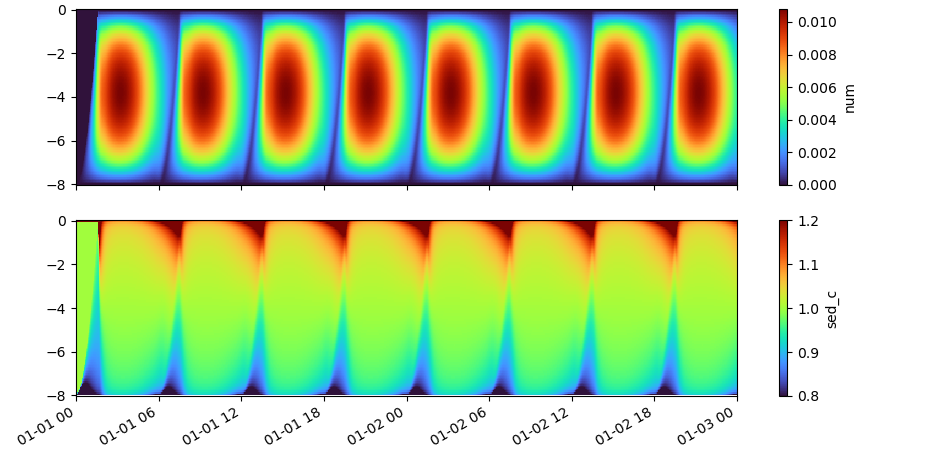

In [209]:
fig=glm.fig_time_z(['num','sed_c'],column=True)
fig.axes[1].collections[0].set_clim(0.8,1.2)

In [210]:
# Calculate what a kappa u* (z-H)*(z/H-1) sort of scaling would look like
H=glm.gotm_yaml['location']['depth']
turb_L = (glm.results.zi_coord - -H) * (glm.results.zeta - glm.results.zi_coord) / H

u_star = np.sqrt( glm.results['taub'] / glm.results['rho'].mean(dim='z'))

para_visc = 0.4 * u_star * turb_L
glm.results['nu_para'] = para_visc

First mixing comparison
--

Default friction, force velocity of $\pm$0.75 m/s.

Evidence of unsteadiness, but relatively short term. Maybe an hour.

Is this a function of friction? I had to turn friction down substantially 
to get the same results as DFM. I think the relevant settings is `bottom/h0b` and
is currently set to 0.03 m, which sounds quite large. With that value,
peak salt dispersivity is 0.026 m2/s.

Dropping roughness to a Bay-ish value of 0.001 m drops max GOTM dispsersivity
to 0.019 m2/s and parabolic 0.020.

**Check** DFM and harmonics velocity. What is a comparable velocity range?

(10228.24, 10228.895)

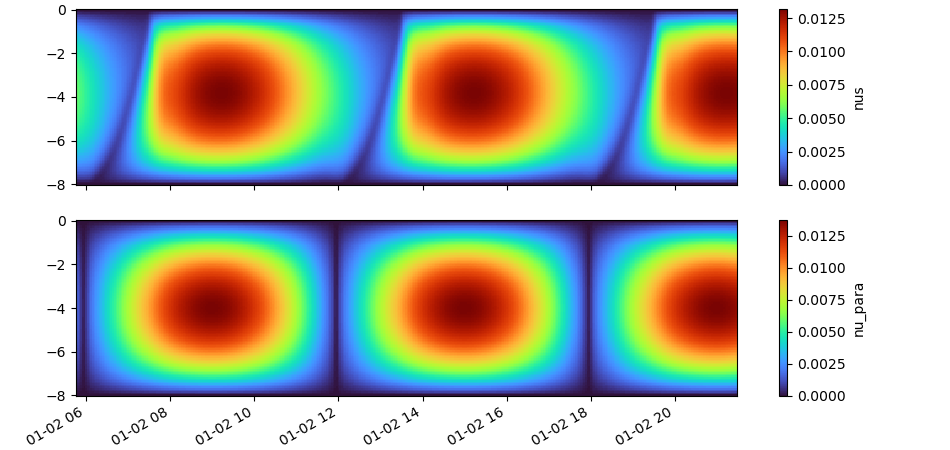

In [211]:
fig=glm.fig_time_z(
    ['nus','nu_para'],
   column=True)
fig.axes[0].set_xlim((10228.24, 10228.895))

In [189]:
fig.axes[0].axis()


(10228.24038123023, 10228.895323034649, -7.755669282937243, 0.1553920035359866)

In [184]:
glm.results

<xarray.Dataset>
Dimensions:     (time: 201, z: 110, zi: 111)
Coordinates:
  * time        (time) datetime64[ns] 1998-01-01 ... 1998-01-03
    lon         float32 0.0
    lat         float32 0.0
    z_coord     (time, z) float32 -7.964 -7.891 -7.818 ... -0.1091 -0.03636
    zi_coord    (time, zi) float32 -8.0 -7.927 -7.855 ... -0.07273 -4.619e-14
Dimensions without coordinates: z, zi
Data variables: (12/106)
    zeta        (time) float32 ...
    u_taus      (time) float32 ...
    Hice        (time) float32 ...
    u10         (time) float32 ...
    v10         (time) float32 ...
    airt        (time) float32 ...
    ...          ...
    vs0         (time) float32 ...
    ds          (time) float32 ...
    Ekin        (time) float32 ...
    Epot        (time) float32 ...
    Eturb       (time) float32 ...
    nu_para     (time, zi) float32 0.0 0.0 0.0 ... 0.0008081 0.0004078 2.613e-16
Attributes:
    title:    GOTM Simulation
    comment:  file created by flexout - https://github.com/BoldingBruggeman/f...